In [1]:
%pylab inline

import anacal
import numpy as np
import matplotlib.pylab as plt

import lsst.geom as geom
from lsst.afw.geom import makeSkyWcs
import fitsio
import os

# LSST task to define DC2-like skymap 
from lsst.skymap.discreteSkyMap import (
    DiscreteSkyMapConfig, DiscreteSkyMap,
)
from lsst.pipe.tasks.coaddBase import makeSkyInfo

from xlens.simulator.catalog import (
    CatalogLogNormalTask,
    CatalogLogNormalTaskConfig,
)
from xlens.simulator.sim import (
    MultibandSimConfig, MultibandSimTask
)

# Detection Task: Detect, shape measurement
from xlens.process_pipe.anacal_detect import (
    AnacalDetectPipeConfig, 
    AnacalDetectPipe,
)

# Force color measurement Task: 
# flux measurement on the other bands
from xlens.process_pipe.anacal_force import (
    AnacalForcePipe,
    AnacalForcePipeConfig,
)

# Match Task: match to input catalog
from xlens.process_pipe.match import (
    matchPipe,
    matchPipeConfig,
)

from astropy.visualization import ZScaleInterval

# NaMASTER is required
import pymaster as nmt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Initialize SkyMap

In [2]:
pixel_scale = 0.2
mag_zero = 30
config = DiscreteSkyMapConfig()
config.projection = "TAN"

# Define tract center explicitly 
config.raList = [0.0]         # degrees
config.decList = [0.0]        # degrees
config.radiusList = [0.1]     # radius in degrees

config.rotation = 0.0         # tract rotation in degrees

# Patch and tract configuration
config.patchInnerDimensions = [4000, 4000]  # inner size of patch in pixels
config.patchBorder = 100                    # border size in pixels
config.pixelScale = pixel_scale             # arcsec/pixel
config.tractOverlap = 0.0                   # no overlap

# Create the skymap
skymap = DiscreteSkyMap(config)

# Make Image Simulation

In [3]:
band = "i"
tract_id = 0
patch_id = 0

# configuration
config = CatalogLogNormalTaskConfig()

cattask = CatalogLogNormalTask(config=config)
truthCatalog = cattask.run(
    tract_info=skymap[tract_id],
    seed=0,
).truthCatalog

config = MultibandSimConfig()
config.survey_name = "lsst"
config.draw_image_noise = True
simtask = MultibandSimTask(config=config)
outcome = simtask.run(
    tract_info=skymap[tract_id],
    patch_id=patch_id,
    band="i",
    seed=0,
    truthCatalog=truthCatalog,
)

In [4]:
# Input shear field
shear_field = cattask.get_perturbation_object(    
    tract_info=skymap[tract_id],
    seed=0,
)
side_deg = shear_field.field_size_deg

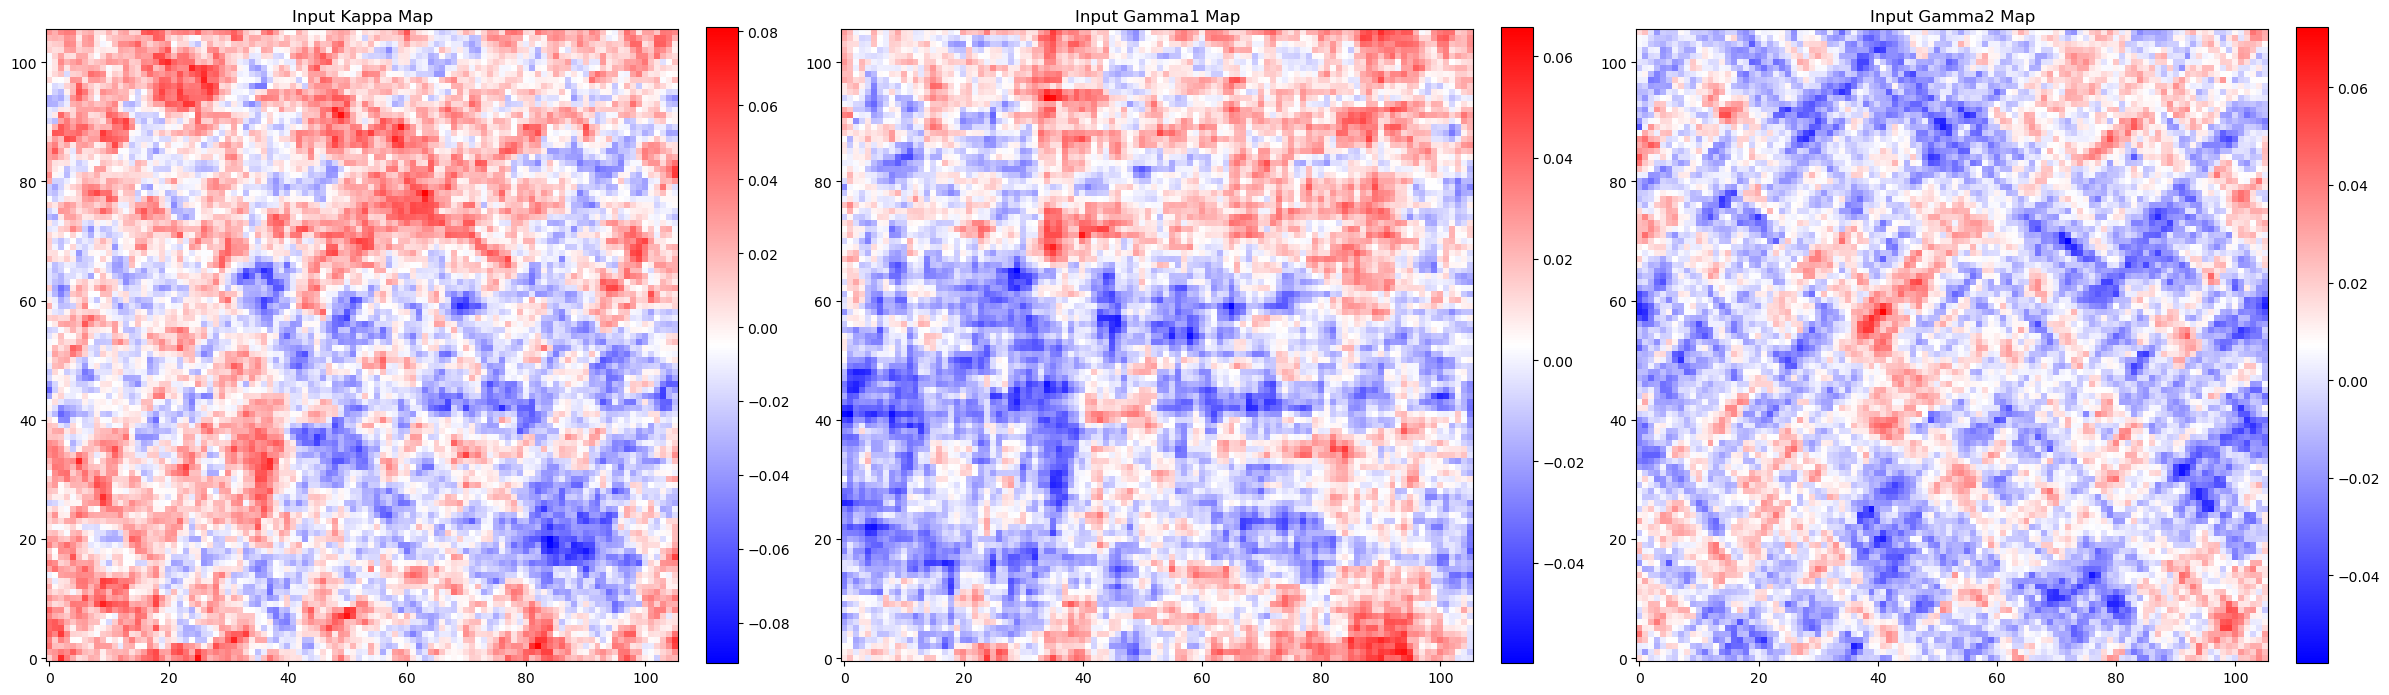

In [5]:
kappa_map = shear_field.kappa_LN_map
gamma1_map = shear_field.gamma1_map
gamma2_map = shear_field.gamma2_map

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

im_kappa = axes[0].imshow(kappa_map.T, origin='lower', cmap='bwr')
axes[0].set_title("Input Kappa Map")
fig.colorbar(im_kappa, ax=axes[0], fraction=0.046, pad=0.04)

im_gamma1 = axes[1].imshow(gamma1_map.T, origin='lower', cmap='bwr')
axes[1].set_title("Input Gamma1 Map")
fig.colorbar(im_gamma1, ax=axes[1], fraction=0.046, pad=0.04)

im_gamma2 = axes[2].imshow(gamma2_map.T, origin='lower', cmap='bwr')
axes[2].set_title("Input Gamma2 Map")
fig.colorbar(im_gamma2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()

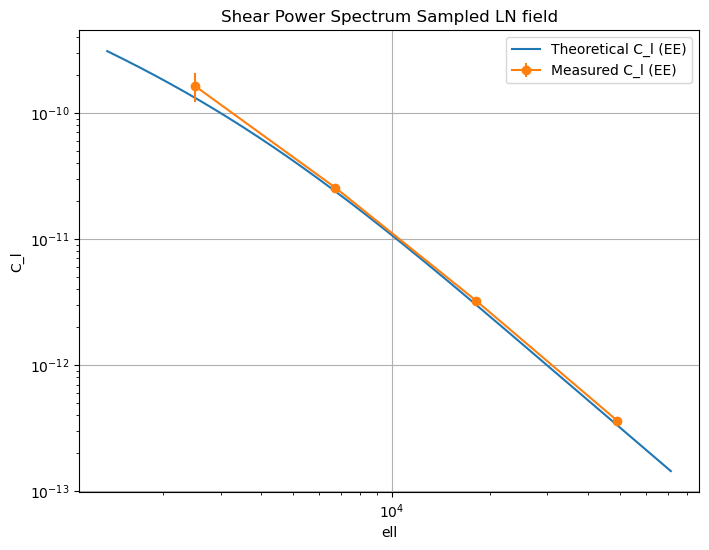

In [6]:
npix = shear_field.npix
field_size_deg = shear_field.field_size_deg
lx = ly = np.deg2rad(field_size_deg)
mask = np.ones([npix, npix])
# mask = nmt.mask_apodization_flat(mask, lx, ly, aposize=0.5, apotype='C1')

# Define binning scheme
l_min = 2 * np.pi / lx
l_max = np.pi / (lx / npix)
ell_bins = np.logspace(np.log10(l_min), np.log10(l_max), 5)
b = nmt.NmtBinFlat(ell_bins[:-1], ell_bins[1:])
ell_binned = b.get_effective_ells()

ell_theory, cl_theory = shear_field.ell, shear_field.cl_kappa
gamma1_map = shear_field.gamma1_map
gamma2_map = shear_field.gamma2_map
f_s = nmt.NmtFieldFlat(lx, ly, mask, [gamma1_map, gamma2_map], spin=2)

# Compute workspace and decoupled power spectrum
w = nmt.NmtWorkspaceFlat()
w.compute_coupling_matrix(f_s, f_s, b)
cl_coupled = nmt.compute_coupled_cell_flat(f_s, f_s, b)
cl_uncoupled = w.decouple_cell(cl_coupled)

# Gaussian Cov
cw = nmt.NmtCovarianceWorkspaceFlat()
cw.compute_coupling_coefficients(f_s, f_s, b)
cl_th_EE = cl_theory
cl_th_EB = np.zeros_like(cl_theory)
cl_th_BE = np.zeros_like(cl_theory)
cl_th_BB = np.zeros_like(cl_theory)
cl_th_ss = [cl_th_EE, cl_th_EB, cl_th_BE, cl_th_BB]
cov_matrix = nmt.gaussian_covariance_flat(cw, 2, 2, 2, 2,
                                          ell_theory,    # larr in the example
                                          cl_th_ss,      # cl_th_a1b1
                                          cl_th_ss,      # cl_th_a1b2
                                          cl_th_ss,      # cl_th_a2b1
                                          cl_th_ss,      # cl_th_a2b2
                                          w)             # Pass the Cl workspace 'w'
nbins = b.get_n_bands()
nspec = 4
cov_matrix_flat = cov_matrix.reshape([nspec * nbins, nspec * nbins])
diag_vars = np.diag(cov_matrix_flat)
gauss_err = np.sqrt(diag_vars).reshape([nspec, nbins])

plt.figure(figsize=(8, 6))
plt.plot(ell_theory, cl_theory, '-', label='Theoretical C_l (EE)')
plt.errorbar(ell_binned, cl_uncoupled[0], yerr=gauss_err[0], marker='o', label='Measured C_l (EE)')
# plt.errorbar(ell_binned, cl_uncoupled[1], yerr=gauss_err[1], marker='s', label='Measured C_l (EB)')
# plt.errorbar(ell_binned, cl_uncoupled[2], yerr=gauss_err[2], marker='v', label='Measured C_l (BE)')
# plt.errorbar(ell_binned, cl_uncoupled[3], yerr=gauss_err[3], marker='^', label='Measured C_l (BB)')
plt.xlabel('ell')
plt.ylabel('C_l')
plt.title('Shear Power Spectrum Sampled LN field')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, 'DEC (deg)')

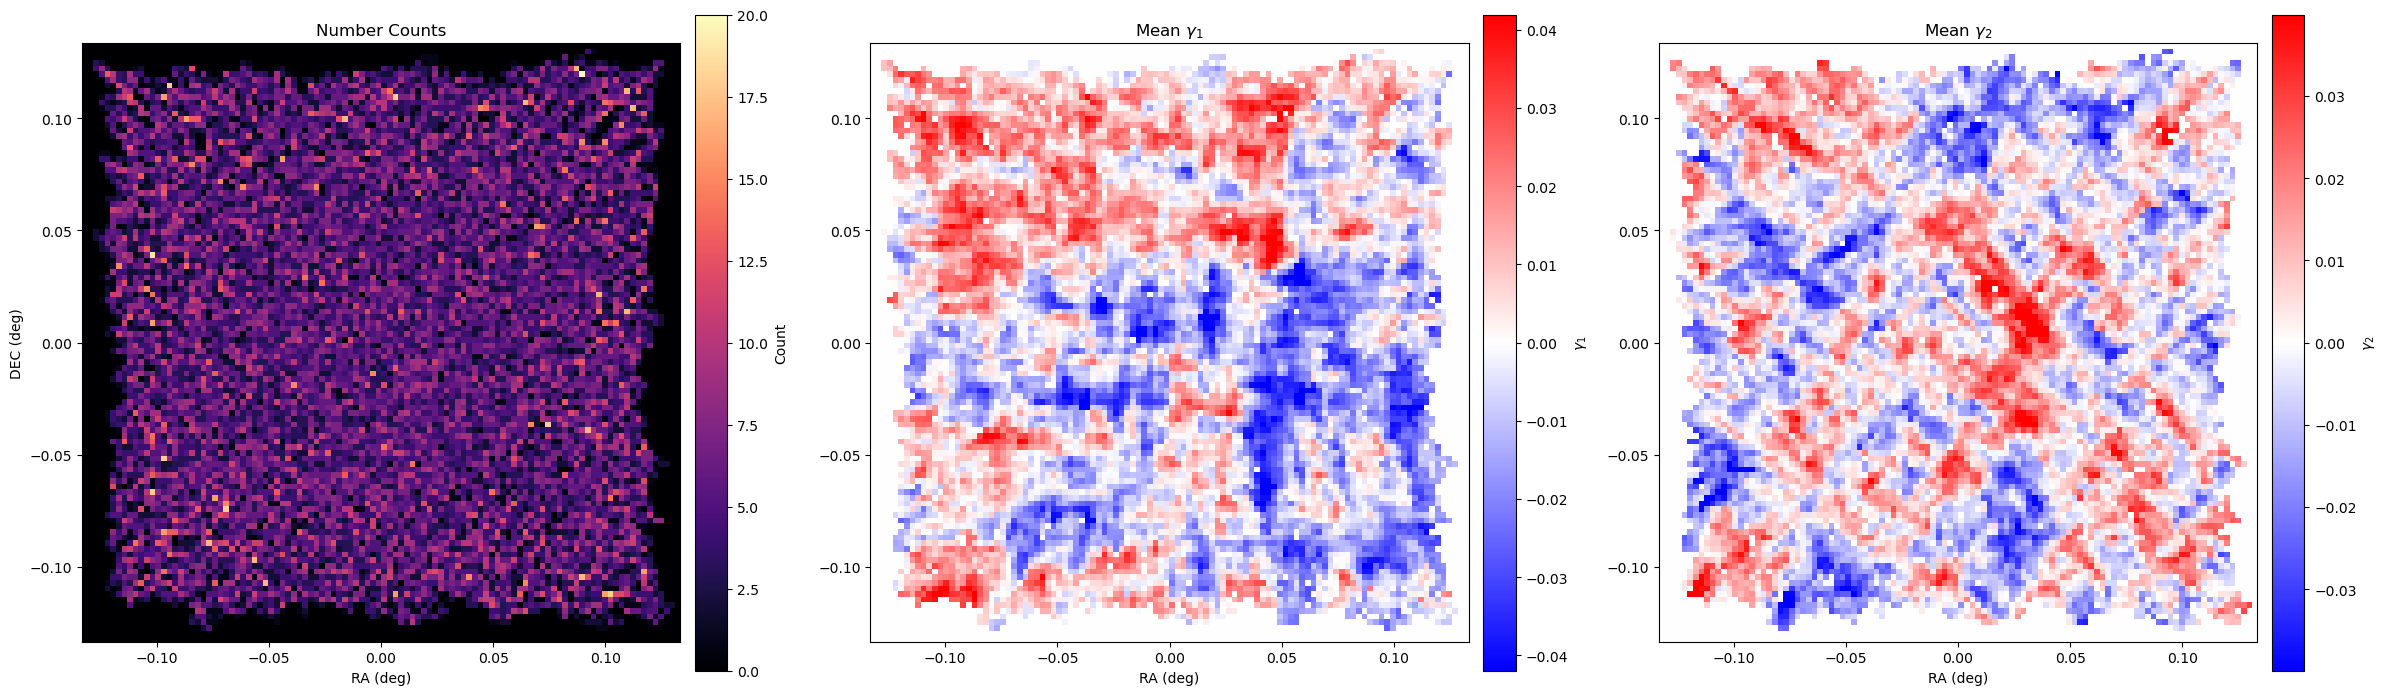

In [7]:
import pymaster as nmt
from scipy.stats import binned_statistic_2d

Lx = Ly = np.deg2rad(field_size_deg) # Map size in radians

cat_ra_rad = np.deg2rad(np.where(truthCatalog['ra'] > 180, truthCatalog['ra'] - 360, truthCatalog['ra']))
cat_dec_rad = np.deg2rad(truthCatalog['dec'])
cat_gamma1 = truthCatalog['gamma1']
cat_gamma2 = truthCatalog['gamma2']

map_bins = [npix, npix]
map_range = [[-Lx/2, Lx/2], [-Ly/2, Ly/2]]

def create_map_from_catalog(values, statistic_type):
    """
    Helper function to bin catalog data into a 2D map.
    Returns a (Ny, Nx) map, transposed from SciPy's (Nx, Ny) output.
    """
    stat, _, _, _ = binned_statistic_2d(
        cat_ra_rad, cat_dec_rad, values,
        statistic=statistic_type,
        bins=map_bins,
        range=map_range
    )
    # Transpose to (Ny, Nx) and convert NaNs (empty bins) to 0
    return np.nan_to_num(stat.T, nan=0.0)

number_counts_map = create_map_from_catalog(cat_ra_rad, 'count') 
map_gamma1_mean = create_map_from_catalog(cat_gamma1, 'sum') 
map_gamma2_mean = create_map_from_catalog(cat_gamma2, 'sum')
ipgood = (number_counts_map > 0)
map_gamma1_mean[ipgood] /= number_counts_map[ipgood]
map_gamma2_mean[ipgood] /= number_counts_map[ipgood]

assert truthCatalog.shape[0] == np.sum(number_counts_map)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 7), tight_layout=True)
extent_deg = [-side_deg/2, side_deg/2, -side_deg/2, side_deg/2]
plot_data = [
    {'title': 'Number Counts', 'map': number_counts_map, 'cmap': 'magma', 'label': 'Count'},
    {'title': r'Mean $\gamma_1$', 'map': map_gamma1_mean,   'cmap': 'bwr',   'label': r'$\gamma_1$'},
    {'title': r'Mean $\gamma_2$', 'map': map_gamma2_mean,   'cmap': 'bwr',   'label': r'$\gamma_2$'}
]

for ax, data in zip(axes, plot_data):
    plot_kwargs = {'origin': 'lower', 'extent': extent_deg, 'cmap': data['cmap']}

    if data['cmap'] == 'bwr':
        # Get robust symmetric color limits for shear maps
        good_pix = data['map'][number_counts_map > 0]
        vmax = np.percentile(np.abs(good_pix), 99)
        plot_kwargs['vmin'] = -vmax
        plot_kwargs['vmax'] = vmax

    im = ax.imshow(data['map'], **plot_kwargs)
    ax.set_title(data['title'])
    ax.set_xlabel('RA (deg)')
    fig.colorbar(im, ax=ax, label=data['label'], pad=0.02)

axes[0].set_ylabel('DEC (deg)')  # Add x-label only to the bottom plot

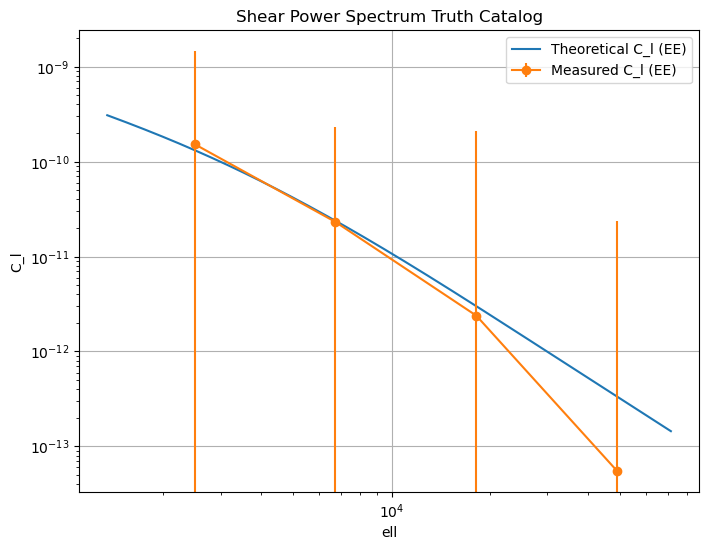

In [8]:
f_shear = nmt.NmtFieldFlat(Lx, Ly, number_counts_map, [map_gamma1_mean, map_gamma2_mean], spin=2)

# noise
cat_sigma_e_sq = 0.5 * (cat_gamma1**2 + cat_gamma2**2)
map_sigma_2_sq = create_map_from_catalog(cat_sigma_e_sq, 'sum')
nl = Lx * Ly * map_sigma_2_sq.sum() / npix**2 / npix**2

# ell_bins = np.logspace(np.log10(l_min), np.log10(l_max), 3)
# b = nmt.NmtBinFlat(ell_bins[:-1], ell_bins[1:])
# ell_binned = b.get_effective_ells()

w22 = nmt.NmtWorkspaceFlat()
w22.compute_coupling_matrix(f_shear, f_shear, b)

cl22_coupled = nmt.compute_coupled_cell_flat(f_shear, f_shear, b)
nl_coupled = np.zeros_like(cl22_coupled)
nl_coupled[[0, -1], 2:] = nl
cl22_uncoupled = w22.decouple_cell(cl22_coupled) 
nl_uncoupled = w22.decouple_cell(nl_coupled)
cl22_uncoupled -= nl_uncoupled

# Gaussian Cov
cw = nmt.NmtCovarianceWorkspaceFlat()
cw.compute_coupling_coefficients(f_shear, f_shear, b)
cl_th_EE = cl_theory + nl
cl_th_EB = np.zeros_like(cl_theory)
cl_th_BE = np.zeros_like(cl_theory)
cl_th_BB = np.zeros_like(cl_theory) + nl
cl_th_ss = [cl_th_EE, cl_th_EB, cl_th_BE, cl_th_BB]
cov_matrix = nmt.gaussian_covariance_flat(cw, 2, 2, 2, 2,
                                          ell_theory,    # larr in the example
                                          cl_th_ss,      # cl_th_a1b1
                                          cl_th_ss,      # cl_th_a1b2
                                          cl_th_ss,      # cl_th_a2b1
                                          cl_th_ss,      # cl_th_a2b2
                                          w)             # Pass the Cl workspace 'w'
nbins = b.get_n_bands()
nspec = 4
cov_matrix_flat = cov_matrix.reshape([nspec * nbins, nspec * nbins])
diag_vars = np.diag(cov_matrix_flat)
gauss_err = np.sqrt(diag_vars).reshape([nspec, nbins])


plt.figure(figsize=(8, 6))
plt.plot(ell_theory, cl_theory, '-', label='Theoretical C_l (EE)')
plt.errorbar(ell_binned, cl22_uncoupled[0], yerr=gauss_err[0], marker='o', label='Measured C_l (EE)')
# plt.errorbar(ell_binned, cl_uncoupled[1], yerr=gauss_err[1], marker='s', label='Measured C_l (EB)')
# plt.errorbar(ell_binned, cl_uncoupled[2], yerr=gauss_err[2], marker='v', label='Measured C_l (BE)')
# plt.errorbar(ell_binned, cl_uncoupled[3], yerr=gauss_err[3], marker='^', label='Measured C_l (BB)')
plt.xlabel('ell')
plt.ylabel('C_l')
plt.title('Shear Power Spectrum Truth Catalog')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
# plt.plot(ell_binned, nl_uncoupled[0], ls='--', c='gray')

# plt.plot(ell, cl_kappa, '-')
# plt.plot(ell_binned, cl22_uncoupled[0], 'o')
# plt.plot(ell_binned, cl22_uncoupled[1], 's')
# plt.plot(ell_binned, cl22_uncoupled[2], 'v')
# plt.plot(ell_binned, cl22_uncoupled[3], '^')
# # plt.ylim(1e-15, 1e-9)
# plt.yscale('log')
# plt.xscale('log')

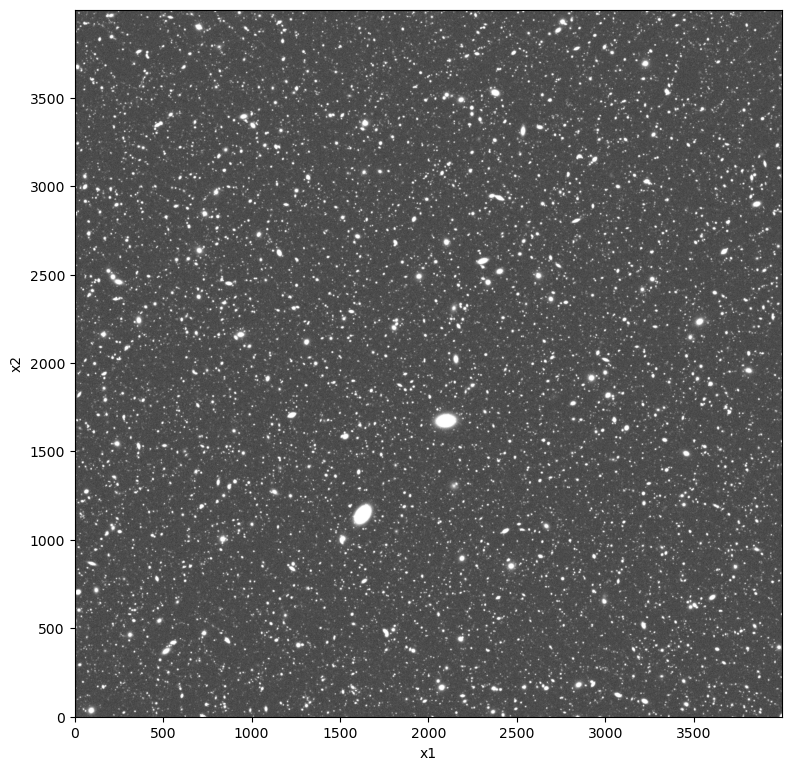

In [9]:
image = outcome.simExposure.image.array
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'PSF')

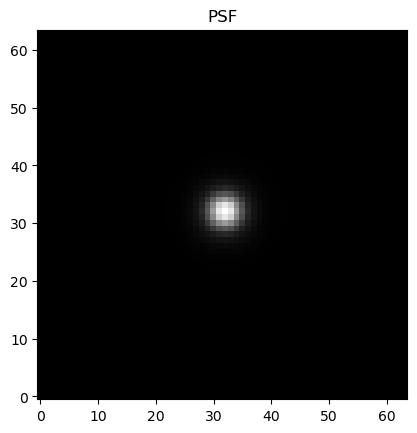

In [10]:
lsst_psf = outcome.simExposure.getPsf()
psf_array = np.asarray(
    anacal.utils.resize_array(
        lsst_psf.computeImage(geom.Point2D(2000, 2000)).getArray(), 
        (64, 64)
    ),
    dtype=np.float64,
)
plt.close()
# Display the PSF image simulation
plt.imshow(psf_array, cmap="Greys_r", origin="lower")
plt.title("PSF")

# Detect and Measure

In [11]:
# Configuration
config = AnacalDetectPipeConfig()
config.anacal.force_size = False
config.anacal.sigma_arcsec = 0.38
config.anacal.num_epochs = 8
config.anacal.do_noise_bias_correction = True
config.anacal.validate_psf = False
config.do_fpfs = True
config.fpfs.sigma_shapelets1 = 0.38 * np.sqrt(2.0)
# Task and preparation
det_task = AnacalDetectPipe(config=config)
seed = (tract_id * 1000 + patch_id) * 5 + 0
data = det_task.anacal.prepare_data(
    exposure=outcome.simExposure,
    seed=seed,
    noise_corr=None,
    detection=None,
    band=band,
    skyMap=skymap,
    tract=tract_id,
    patch=patch_id,
)
# Run catalog
catalog = det_task.run_measure(data)

In [12]:
# Shear Estimation
# e1 = catalog["wsel"] * catalog["i_fpfs1_e1"]
# de1_dg1 = catalog["dwsel_dg1"] * catalog["i_fpfs1_e1"] + catalog["wsel"] * catalog["i_fpfs1_de1_dg1"]

# e2 = catalog["wsel"] * catalog["i_fpfs1_e2"]
# de2_dg2 = catalog["dwsel_dg2"] * catalog["i_fpfs1_e2"] + catalog["wsel"] * catalog["i_fpfs1_de2_dg2"]

e1 = catalog["i_fpfs1_e1"]
de1_dg1 = catalog["i_fpfs1_de1_dg1"]

e2 = catalog["i_fpfs1_e2"]
de2_dg2 = catalog["i_fpfs1_de2_dg2"]

ra = np.where(catalog['ra'] > 180, catalog['ra'] - 360, catalog['ra'])
print(ra.min(), ra.max())
dec = catalog['dec']
print(dec.min(), dec.max())

-0.10888875779477303 0.10883320243975547
-0.10877763894381737 0.10888875166682793


Text(0, 0.5, 'DEC (deg)')

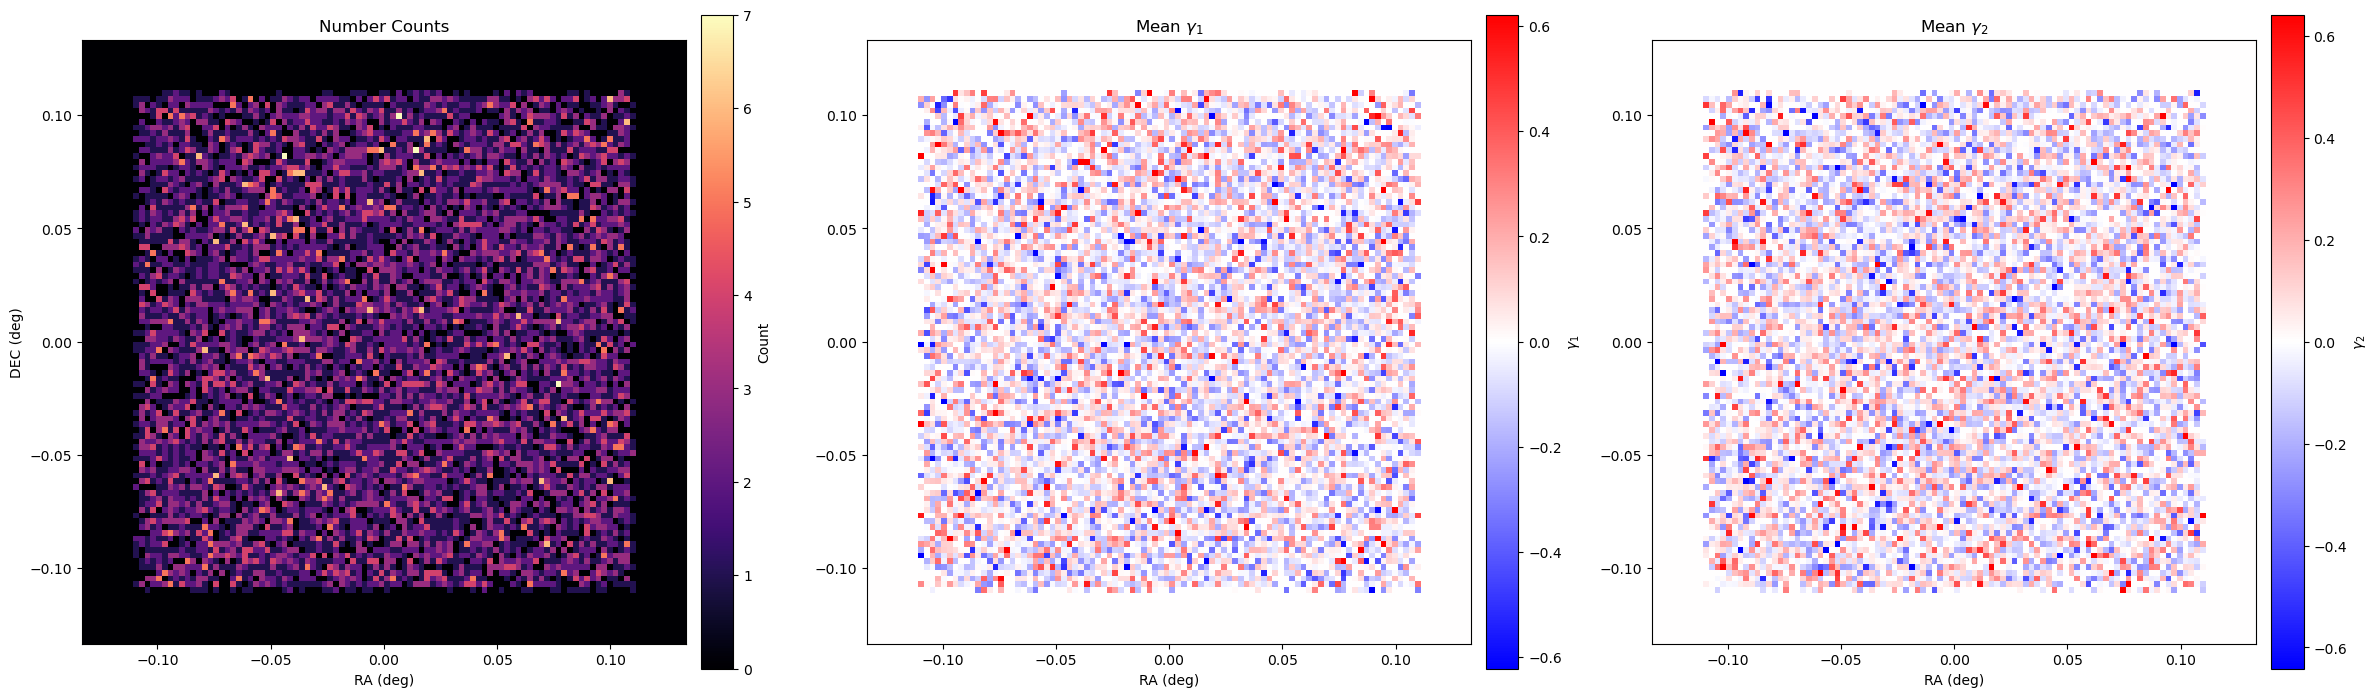

In [13]:
import pymaster as nmt
from scipy.stats import binned_statistic_2d

Lx = Ly = np.deg2rad(field_size_deg) # Map size in radians

cat_ra_rad = np.deg2rad(np.where(catalog['ra'] > 180, catalog['ra'] - 360, catalog['ra']))
cat_dec_rad = np.deg2rad(catalog['dec'])
cat_gamma1 = e1 / np.mean(de1_dg1 + de2_dg2)
cat_gamma2 = e2 / np.mean(de1_dg1 + de2_dg2)

map_bins = [npix, npix]
map_range = [[-Lx/2, Lx/2], [-Ly/2, Ly/2]]

def create_map_from_catalog(values, statistic_type):
    """
    Helper function to bin catalog data into a 2D map.
    Returns a (Ny, Nx) map, transposed from SciPy's (Nx, Ny) output.
    """
    stat, _, _, _ = binned_statistic_2d(
        cat_ra_rad, cat_dec_rad, values,
        statistic=statistic_type,
        bins=map_bins,
        range=map_range
    )
    # Transpose to (Ny, Nx) and convert NaNs (empty bins) to 0
    return np.nan_to_num(stat.T, nan=0.0)

number_counts_map = create_map_from_catalog(cat_ra_rad, 'count') 
map_gamma1_mean = create_map_from_catalog(cat_gamma1, 'sum') 
map_gamma2_mean = create_map_from_catalog(cat_gamma2, 'sum')
ipgood = (number_counts_map > 0)
map_gamma1_mean[ipgood] /= number_counts_map[ipgood]
map_gamma2_mean[ipgood] /= number_counts_map[ipgood]

assert catalog.shape[0] == np.sum(number_counts_map)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 7), tight_layout=True)
extent_deg = [-side_deg/2, side_deg/2, -side_deg/2, side_deg/2]
plot_data = [
    {'title': 'Number Counts', 'map': number_counts_map, 'cmap': 'magma', 'label': 'Count'},
    {'title': r'Mean $\gamma_1$', 'map': map_gamma1_mean,   'cmap': 'bwr',   'label': r'$\gamma_1$'},
    {'title': r'Mean $\gamma_2$', 'map': map_gamma2_mean,   'cmap': 'bwr',   'label': r'$\gamma_2$'}
]

for ax, data in zip(axes, plot_data):
    plot_kwargs = {'origin': 'lower', 'extent': extent_deg, 'cmap': data['cmap']}

    if data['cmap'] == 'bwr':
        # Get robust symmetric color limits for shear maps
        good_pix = data['map'][number_counts_map > 0]
        vmax = np.percentile(np.abs(good_pix), 99)
        plot_kwargs['vmin'] = -vmax
        plot_kwargs['vmax'] = vmax

    im = ax.imshow(data['map'], **plot_kwargs)
    ax.set_title(data['title'])
    ax.set_xlabel('RA (deg)')
    fig.colorbar(im, ax=ax, label=data['label'], pad=0.02)

axes[0].set_ylabel('DEC (deg)')  # Add x-label only to the bottom plot

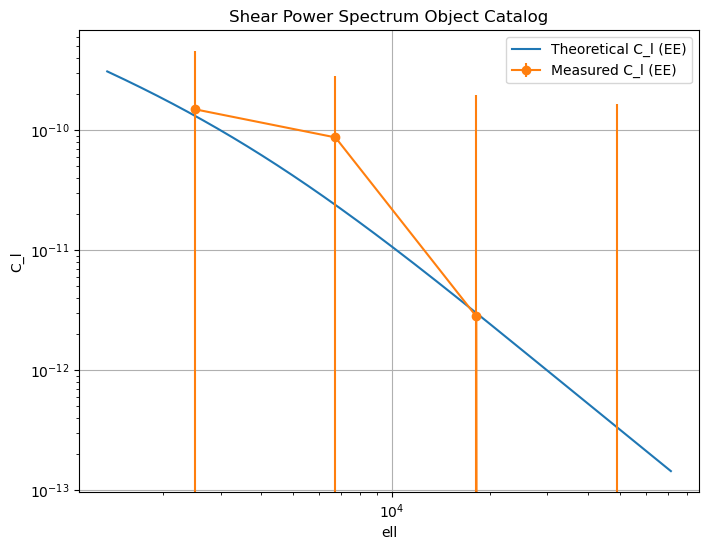

In [14]:
f_shear = nmt.NmtFieldFlat(Lx, Ly, number_counts_map, [map_gamma1_mean, map_gamma2_mean], spin=2)

# noise
cat_sigma_e_sq = 0.5 * (cat_gamma1**2 + cat_gamma2**2)
map_sigma_2_sq = create_map_from_catalog(cat_sigma_e_sq, 'sum')
nl = Lx * Ly * map_sigma_2_sq.sum() / npix**2 / npix**2

# ell_bins = np.logspace(np.log10(l_min), np.log10(l_max), 3)
# b = nmt.NmtBinFlat(ell_bins[:-1], ell_bins[1:])
# ell_binned = b.get_effective_ells()

w22 = nmt.NmtWorkspaceFlat()
w22.compute_coupling_matrix(f_shear, f_shear, b)

cl22_coupled = nmt.compute_coupled_cell_flat(f_shear, f_shear, b)
nl_coupled = np.zeros_like(cl22_coupled)
nl_coupled[[0, -1], 2:] = nl
cl22_uncoupled = w22.decouple_cell(cl22_coupled) 
nl_uncoupled = w22.decouple_cell(nl_coupled)
cl22_uncoupled -= nl_uncoupled

# Gaussian Cov
cw = nmt.NmtCovarianceWorkspaceFlat()
cw.compute_coupling_coefficients(f_shear, f_shear, b)
cl_th_EE = cl_theory + nl
cl_th_EB = np.zeros_like(cl_theory)
cl_th_BE = np.zeros_like(cl_theory)
cl_th_BB = np.zeros_like(cl_theory) + nl
cl_th_ss = [cl_th_EE, cl_th_EB, cl_th_BE, cl_th_BB]
cov_matrix = nmt.gaussian_covariance_flat(cw, 2, 2, 2, 2,
                                          ell_theory,    # larr in the example
                                          cl_th_ss,      # cl_th_a1b1
                                          cl_th_ss,      # cl_th_a1b2
                                          cl_th_ss,      # cl_th_a2b1
                                          cl_th_ss,      # cl_th_a2b2
                                          w)             # Pass the Cl workspace 'w'
nbins = b.get_n_bands()
nspec = 4
cov_matrix_flat = cov_matrix.reshape([nspec * nbins, nspec * nbins])
diag_vars = np.diag(cov_matrix_flat)
gauss_err = np.sqrt(diag_vars).reshape([nspec, nbins])


plt.figure(figsize=(8, 6))
plt.plot(ell_theory, cl_theory, '-', label='Theoretical C_l (EE)')
plt.errorbar(ell_binned, cl22_uncoupled[0], yerr=gauss_err[0], marker='o', label='Measured C_l (EE)')
# plt.errorbar(ell_binned, cl_uncoupled[1], yerr=gauss_err[1], marker='s', label='Measured C_l (EB)')
# plt.errorbar(ell_binned, cl_uncoupled[2], yerr=gauss_err[2], marker='v', label='Measured C_l (BE)')
# plt.errorbar(ell_binned, cl_uncoupled[3], yerr=gauss_err[3], marker='^', label='Measured C_l (BB)')
plt.xlabel('ell')
plt.ylabel('C_l')
plt.title('Shear Power Spectrum Object Catalog')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
# plt.plot(ell_binned, nl_uncoupled[0], ls='--', c='gray')

# plt.plot(ell, cl_kappa, '-')
# plt.plot(ell_binned, cl22_uncoupled[0], 'o')
# plt.plot(ell_binned, cl22_uncoupled[1], 's')
# plt.plot(ell_binned, cl22_uncoupled[2], 'v')
# plt.plot(ell_binned, cl22_uncoupled[3], '^')
# # plt.ylim(1e-15, 1e-9)
# plt.yscale('log')
# plt.xscale('log')